<a href="https://colab.research.google.com/github/hamagami/anomaly-detection/blob/main/05_01_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG16ネットワークで抽出した画像特徴をもとに簡単な異常検知を行う

色々なギター画像に対し，ギターに似た画像を異常検知する

In [2]:
# データ取得　画像をたくさんとってきます
!wget https://dl.dropbox.com/s/dmjzsrqa9s22joi/imgs.zip
!unzip -d . imgs.zip

--2020-12-01 13:10:28--  https://dl.dropbox.com/s/dmjzsrqa9s22joi/imgs.zip
Resolving dl.dropbox.com (dl.dropbox.com)... 162.125.9.15, 2620:100:601f:15::a27d:90f
Connecting to dl.dropbox.com (dl.dropbox.com)|162.125.9.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/s/dmjzsrqa9s22joi/imgs.zip [following]
--2020-12-01 13:10:28--  https://dl.dropboxusercontent.com/s/dmjzsrqa9s22joi/imgs.zip
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.9.15, 2620:100:601d:15::a27d:50f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.9.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25799813 (25M) [application/zip]
Saving to: ‘imgs.zip’

imgs.zip            100%[===================>]  24.60M  77.8MB/s    in 0.3s    

2020-12-01 13:10:29 (77.8 MB/s) - ‘imgs.zip’ saved [25799813/25799813]

Archive:  imgs.zip
  inflating: ./imgs/guitar/1.yamaha_cs40jgg_la.jpg 

In [38]:
from keras.applications import VGG16
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import models, optimizers, layers
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras.applications.resnet50 import preprocess_input
from sklearn.svm import OneClassSVM

import glob  
from PIL import Image 
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.image as mpimg
import random

## 画像のサイズを調整

In [4]:
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

## VGG16ネットワークを取得

In [5]:
model = VGG16(weights='imagenet', include_top=False, pooling="avg")

58892288/58889256 [==============================] - 0s 0us/step


## 画像から特徴を取り出す関数

In [6]:
def feature_extraction(model, img_path, image_size=224):
    im=load_img(f)
    img = expand2square(im, (128, 128, 128)).resize((image_size, image_size))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)  # add a dimention of samples
    x = preprocess_input(x)  # RGB 2 BGR and zero-centering by mean pixel based on the position of channels

    feat = model.predict(x)  # Get image features
    feat = feat.flatten()  # Convert 3-dimentional matrix to (1, n) array

    return feat

## ギター画像の特徴抽出

./imgs/guitar/89.astrius_custom_s_630-thumb-200xauto-4529.jpg


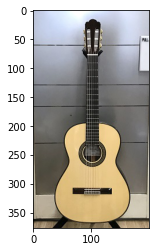

./imgs/guitar/extened-45_0_29.jpg


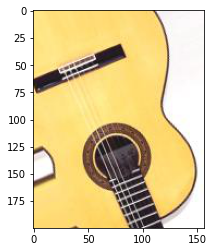

./imgs/guitar/extened-27_0_2096.jpg


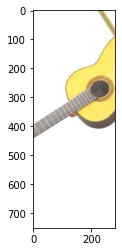

In [46]:
data=[]
files = glob.glob("./imgs/guitar/*") 
# サンプル画像
for f in random.sample(files, 3):
  print(f)
  plt.imshow(mpimg.imread(f))
  plt.show()

In [47]:
# 特徴抽出
for f in files:
        print(f)
        ret= feature_extraction(model, f, 224)
        data.append(ret)

./imgs/guitar/extened-20_0_2645.jpg
./imgs/guitar/extened-7_0_7013.jpg
./imgs/guitar/extened-5_0_5249.jpg
./imgs/guitar/extened-30_0_6091.jpg
./imgs/guitar/extened-38_0_5661.jpg
./imgs/guitar/extened-20_0_2790.jpg
./imgs/guitar/extened-27_0_7405.jpg
./imgs/guitar/33.D1tMz8wg_400x400.jpeg
./imgs/guitar/extened-4_0_6662.jpg
./imgs/guitar/extened-13_0_1016.jpg
./imgs/guitar/extened-28_0_1964.jpg
./imgs/guitar/extened-28_0_4878.jpg
./imgs/guitar/extened-15_0_5239.jpg
./imgs/guitar/extened-21_0_9811.jpg
./imgs/guitar/extened-11_0_504.jpg
./imgs/guitar/extened-8_0_9167.jpg
./imgs/guitar/extened-41_0_7798.jpg
./imgs/guitar/extened-26_0_6839.jpg
./imgs/guitar/extened-30_0_4550.jpg
./imgs/guitar/extened-4_0_1744.jpg
./imgs/guitar/extened-36_0_7416.jpg
./imgs/guitar/extened-17_0_5550.jpg
./imgs/guitar/15.jlrs1.jpg
./imgs/guitar/extened-44_0_8100.jpg
./imgs/guitar/extened-13_0_3461.jpg
./imgs/guitar/extened-30_0_108.jpg
./imgs/guitar/extened-5_0_9990.jpg
./imgs/guitar/extened-30_0_1253.jpg
./imgs

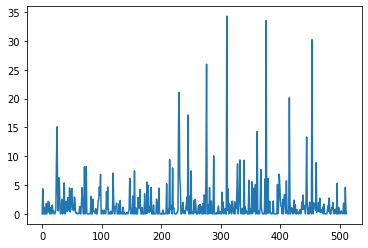

In [48]:
plt.plot(data[0],label="feature value")
plt.show()

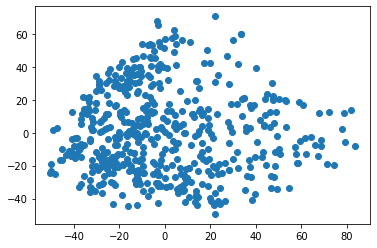

In [49]:
data = np.array(data)
pca = PCA(n_components=2)
pdata =np.array(pca.fit_transform(data))
plt.scatter(pdata.T[0],pdata.T[1])
plt.show()

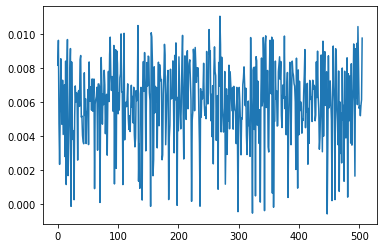

In [64]:
mmscaler = preprocessing.MinMaxScaler() 
mmscaler.fit(data)  
sdata=mmscaler.transform(data)

ocsvm = OneClassSVM(nu=0.001, kernel="rbf", gamma='auto')
ocsvm.fit(sdata)
y_pred = ocsvm.decision_function(sdata).ravel()
plt.plot(y_pred)
plt.show()

In [58]:
len(preds[preds==-1])

9

./imgs/others/classic_guitar.png


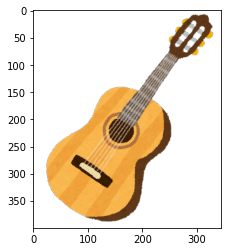

./imgs/others/61xdYKcuO0L._SY355_.jpg


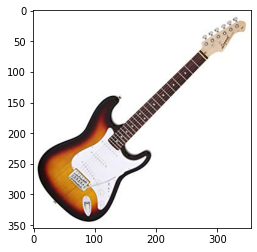

./imgs/others/31OFo14if6L._AC_SS350_.jpg


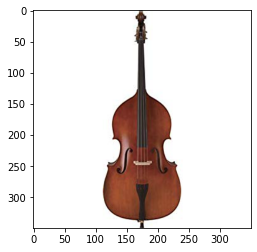

./imgs/others/514N0S1vXRL._SY550_.jpg


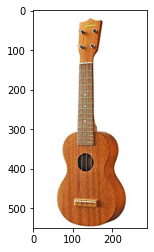

./imgs/others/2016-06-14_Orange_and_white_tabby_cat_born_in_2016_ТГГgГЙФТВ╦В▒_DSCF6526БЩЬc.jpg


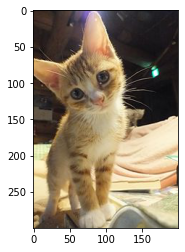

./imgs/others/BAAD5109720944D6B071FDE3916D87B6_12073.jpg


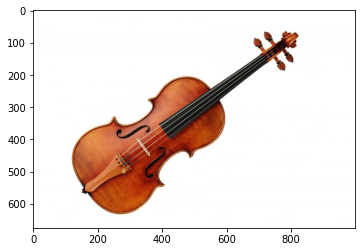

./imgs/others/065-00496_m.jpg


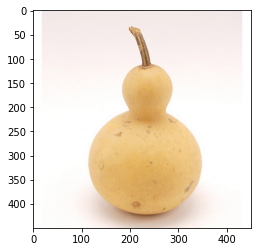

./imgs/others/piano1_yamaha-cfx-bk2.jpg


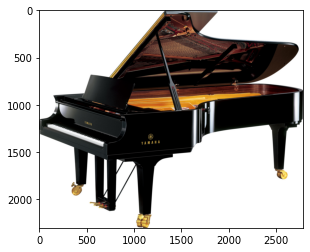

./imgs/others/classic_guitar.png
./imgs/others/61xdYKcuO0L._SY355_.jpg
./imgs/others/31OFo14if6L._AC_SS350_.jpg
./imgs/others/514N0S1vXRL._SY550_.jpg
./imgs/others/2016-06-14_Orange_and_white_tabby_cat_born_in_2016_ТГГgГЙФТВ╦В▒_DSCF6526БЩЬc.jpg
./imgs/others/BAAD5109720944D6B071FDE3916D87B6_12073.jpg
./imgs/others/065-00496_m.jpg
./imgs/others/piano1_yamaha-cfx-bk2.jpg


In [66]:
adata=[]
files = glob.glob("./imgs/others/*")   
for f in files:
  print(f)
  plt.imshow(mpimg.imread(f))
  plt.show()  
for f in files:
        print(f)
        ret= feature_extraction(model, f, 224)
        adata.append(ret)
adata = np.array(adata)
sadata=mmscaler.transform(adata)
apred=ocsvm.predict(sadata)

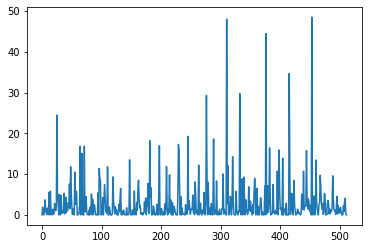

In [62]:
plt.plot(adata[0])
plt.show()

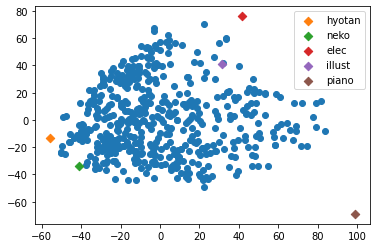

In [65]:
plt.scatter(pdata.T[0],pdata.T[1])
plt.scatter(a_pca_data.T[0][0],a_pca_data.T[1][0],label="hyotan",marker="D")
plt.scatter(a_pca_data.T[0][1],a_pca_data.T[1][1],label="neko",marker="D")
plt.scatter(a_pca_data.T[0][4],a_pca_data.T[1][4],label="elec",marker="D")
plt.scatter(a_pca_data.T[0][6],a_pca_data.T[1][6],label="illust",marker="D")
plt.scatter(a_pca_data.T[0][7],a_pca_data.T[1][7],label="piano",marker="D")
plt.legend()
plt.show()